In [1]:
import pandas as pd
import numpy as np
import os
import glob
from itertools import combinations

from matplotlib import pyplot as plt
from utils import load_dataset_filtered
from transatlantic.utils import get_actual_cases
from itertools import combinations

%matplotlib inline

In [2]:
def realname(path, root=None):
    if root is not None:
        path=os.path.join(root, path)
    result=os.path.basename(path)
    if os.path.islink(path):
        realpath=os.readlink(path)
        result= '%s -> %s' % (os.path.basename(path), realpath)
    return result

def ptree(startpath, depth=-1):
    prefix=0
    if startpath != '/':
        if startpath.endswith('/'): startpath=startpath[:-1]
        prefix=len(startpath)
    for root, dirs, files in os.walk(startpath):
        level = root[prefix:].count(os.sep)
        if depth >-1 and level > depth: continue
        indent=subindent =''
        if level > 0:
            indent = '|   ' * (level-1) + '|-- '
        subindent = '|   ' * (level) + '|-- '
        print('{}{}/'.format(indent, realname(root)))
        # print dir only if symbolic link; otherwise, will be printed as root
        for d in dirs:
            if os.path.islink(os.path.join(root, d)):
                print('{}{}'.format(subindent, realname(d, root=root)))
        for f in files:
            print('{}{}'.format(subindent, realname(f, root=root)))

# Model comparion visualizations

Usage: 
- `SUBMISSIONS_PATH` contains folders of the form `training-ddmmyy-prediction-ddmmyy-ddmmyy` that contain model predictions in separate csv files named `modelname.csv`.

- `training-ddmmyy-prediction-ddmmyy-ddmmyy` means that the models were trained until 1st date and the predictions correspond to the days between the 2nd and 3rd date.

- `MAE_SCORE_DAYS` indicates on how many days to compute MAE w.r.t. 7-day smoothed new cases (default 20 as the judging phase lasts 20 days.

- `RECOMPUTE_SCORES` indicates whether to recompute MAE_i matrices

In [3]:
SUBMISSIONS_PATH = './codalab_plots/scores'
MAE_SCORE_DAYS = 20
RECOMPUTE_SCORES = True

Example for our directory:

In [4]:
ptree(SUBMISSIONS_PATH)

scores/
|-- training-300920-prediction-100120-103020/
|   |-- romain-lasso.csv
|   |-- romain-ridge.csv
|   |-- stacking-lasso-ridge-linearSVR.csv
|   |-- stacking-lassocv-ridgecv-w=21.csv


In [5]:
def mae_i(pred, true, i):
        """
            Compute Mean Average Error between predictions and groundtruth over i first days
        """
        return np.mean(np.abs(pred[:i] - true[:i]))

## Compute MAE-i scores per country per model

In [6]:
folders = [os.path.split(os.path.dirname(f))[1] for f in glob.glob(SUBMISSIONS_PATH+'/*/')]

if RECOMPUTE_SCORES:
    # Load real data only on evaluated locations
    df_groundtruth = load_dataset_filtered(data_file='./data/OxCGRT_latest.csv', 
                               countries_regions_file='./covid-xprize-uptodate/countries_regions.csv')

    # Filter to have new cases and 7-smoothed new cases
    df_groundtruth = get_actual_cases(df_groundtruth, min(df_groundtruth.Date), max(df_groundtruth.Date))
    df_groundtruth.reset_index(drop=True, inplace=True)
    df_groundtruth.ConfirmedCases.bfill(inplace=True)
    df_groundtruth.ActualDailyNewCases7DMA.bfill(inplace=True)

    # Get list of evaluated locations
    locations_list = df_groundtruth.GeoID.unique()

    # Storage of per_folder ranking dfs
    dfs = []

    for folder in folders:
        # Recover test dates
        pred_begin, pred_end = folder.split('-')[-2:]

        date_begin = pd.to_datetime(pred_begin, format='%m%d%y')
        date_end = pd.to_datetime(pred_end, format='%m%d%y')
        
        # Recover team submission files & team names
        fpath = SUBMISSIONS_PATH + '/' + folder + '/'
        files = glob.glob(fpath+'*.csv', recursive=True)
        teams = [os.path.split(f)[1][:-4] for f in files]

        # Storage df
        df_test_period = pd.DataFrame()
        df_test_period['GeoID'] = locations_list

        for i, submission in enumerate(files):
            team = teams[i]
            # Read submission
            team_df = pd.read_csv(submission,
                          parse_dates=['Date'],
                          encoding="ISO-8859-1",
                          dtype={"CountryName": str,
                                 "RegionCode": str},
                          error_bad_lines=False)
            team_df["RegionName"] = team_df["RegionName"].fillna("")
            # Create GeoID
            team_df["GeoID"] = np.where(team_df["RegionName"].isnull(),
                                      team_df["CountryName"],
                                      team_df["CountryName"] + ' / ' + team_df["RegionName"])
            team_df.sort_values(by=["GeoID","Date"], inplace=True)
            
            # Score storage
            locations_scores = np.zeros(len(locations_list))
            
            # Per GeoID
            for j, location in enumerate(locations_list):
                # Recover true number of cases
                team_gt = df_groundtruth[(df_groundtruth.GeoID == location) &
                                         (df_groundtruth.Date >= date_begin) &
                                         (df_groundtruth.Date <= date_end)].ActualDailyNewCases7DMA.values
                # Recover predictions
                team_pred = team_df[team_df.GeoID == location].PredictedDailyNewCases.values

                # Compute MAE_i
                maes_loc = mae_i(team_gt, team_pred, MAE_SCORE_DAYS)
                # Assign MAE per location
                locations_scores[j] = maes_loc
                
            # Add team MAEs per location
            df_test_period[team] = locations_scores
        
        # HERE: Per-country per-model df ready
        # Recover country-region from GeoID
        df_test_period[["CountryName", "RegionName"]] = df_test_period.GeoID.apply(
            lambda x: pd.Series(str(x).split(" / ")))
        df_test_period.drop('GeoID', axis=1, inplace=True)

        # Swap order of country/region to be 1st in final df
        cols = list(df_test_period.columns)
        cols = cols[-2:] + cols[:-2]
        df_test_period = df_test_period[cols]
        
        dfs.append(df_test_period)
        
        # Save to file
        df_name = f'{pred_begin}_{pred_end}_test-{MAE_SCORE_DAYS}_scoring.csv'
        df_test_period.to_csv(SUBMISSIONS_PATH+'/'+df_name, index=False)
        print(f'Saved {MAE_SCORE_DAYS}MAE over {pred_begin}-{pred_end}')
    
    # Reassign boolean to not rerun again
    RECOMPUTE_SCORES = False
else:
    print(f'Not recomputing {MAE_SCORE_DAYS}MAE')

Saved 20MAE over 100120-103020


## Ranking computing

In [7]:
# Recover savec summary csvs
available_MAEcsv = glob.glob(SUBMISSIONS_PATH+'/*.csv')

available_MAEcsv

['./codalab_plots/scores\\100120_103020_test-20_scoring.csv']

In [8]:
# Create ranking df from score df
month_dfs = []
for file in available_MAEcsv:
    if 'ranking' in file:
        continue
    month_df = pd.read_csv(file,
                          dtype={"CountryName": str,
                                 "RegionName": str},
                          error_bad_lines=False)
    # Model names are all columns after CountryName and RegionName
    model_cols = list(month_df.columns)[2:]
    # Ranking is argsort of MAE
    ranking = np.argsort(month_df[model_cols], axis=1)
    # Assign rankings
    month_df[model_cols] = ranking
    # Save csv of ranking df
    month_df.to_csv(file.replace('scoring', 'ranking'), index=False)
    month_dfs.append(month_df)

## Visualizing

### Plotting functions

In [9]:
def plot_ranking(ranking_df):

    model_cols = list(ranking_df.columns)[2:]

    geoids = np.where(ranking_df["RegionName"].isnull(),
                      ranking_df["CountryName"],
                      ranking_df["CountryName"] + ' / ' + ranking_df["RegionName"])



    best = np.apply_along_axis(np.argmin, 1, ranking_df[model_cols])
    _, perf = np.unique(best, return_counts=True)

    xlabels = [model+f'\n({perf[i]})' for i, model in enumerate(model_cols)]

    fig, ax = plt.subplots(figsize=(7, 45), tight_layout=True, dpi=400.0, facecolor='white')

    ax.scatter(best ,ranking_df.index)

    x_ticks = list(range(len(model_cols)))
    y_ticks = list(range(len(geoids)))

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xlabels, rotation=45)

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(geoids)
    ax.set_xlabel('Models')

    # Plot country line to identify model
    ax.hlines(y=y_ticks, xmin=-0.1, xmax=best, ls='dotted')

    plt.show()

In [10]:
def pairwise_models(df_toplot):
    """Plots model pairwise comparison of MAE errors per country
        :param df_toplot: contains #geo_id rows, (2 + #models) columns and
                          each entry i,j is MAE_n of model j on ocountry i
    """
    
    # Get all models in df
    models = list(df_toplot.columns)[2:]

    # Compute max error accross all models to normalize plot axa
    max_error = max(df_toplot[models].values.ravel())

    # Tags
    geoids = np.where(df_toplot["RegionName"].isnull(),
                      df_toplot["CountryName"],
                      df_toplot["CountryName"] + ' / ' + df_toplot["RegionName"])

    # Combinations to plot
    pairs = list(combinations(models, 2))

    for m1, m2 in pairs:
        x = df_toplot[m1].values
        y = df_toplot[m2].values

        # Plot MAE
        fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True, dpi=400.0, facecolor='white')
        ax.scatter(x, y)
        # Axa limits
        ax.set_ylim(0.0, max_error)
        ax.set_xlim(0.0, max_error)    
        # Decision line
        ax.plot([0, 1], [0, 1] ,c='r', transform=ax.transAxes)
        # Labels
        ax.set_xlabel(m1)
        ax.set_ylabel(m2)

        # fig visualization
        plt.show()

### Plots

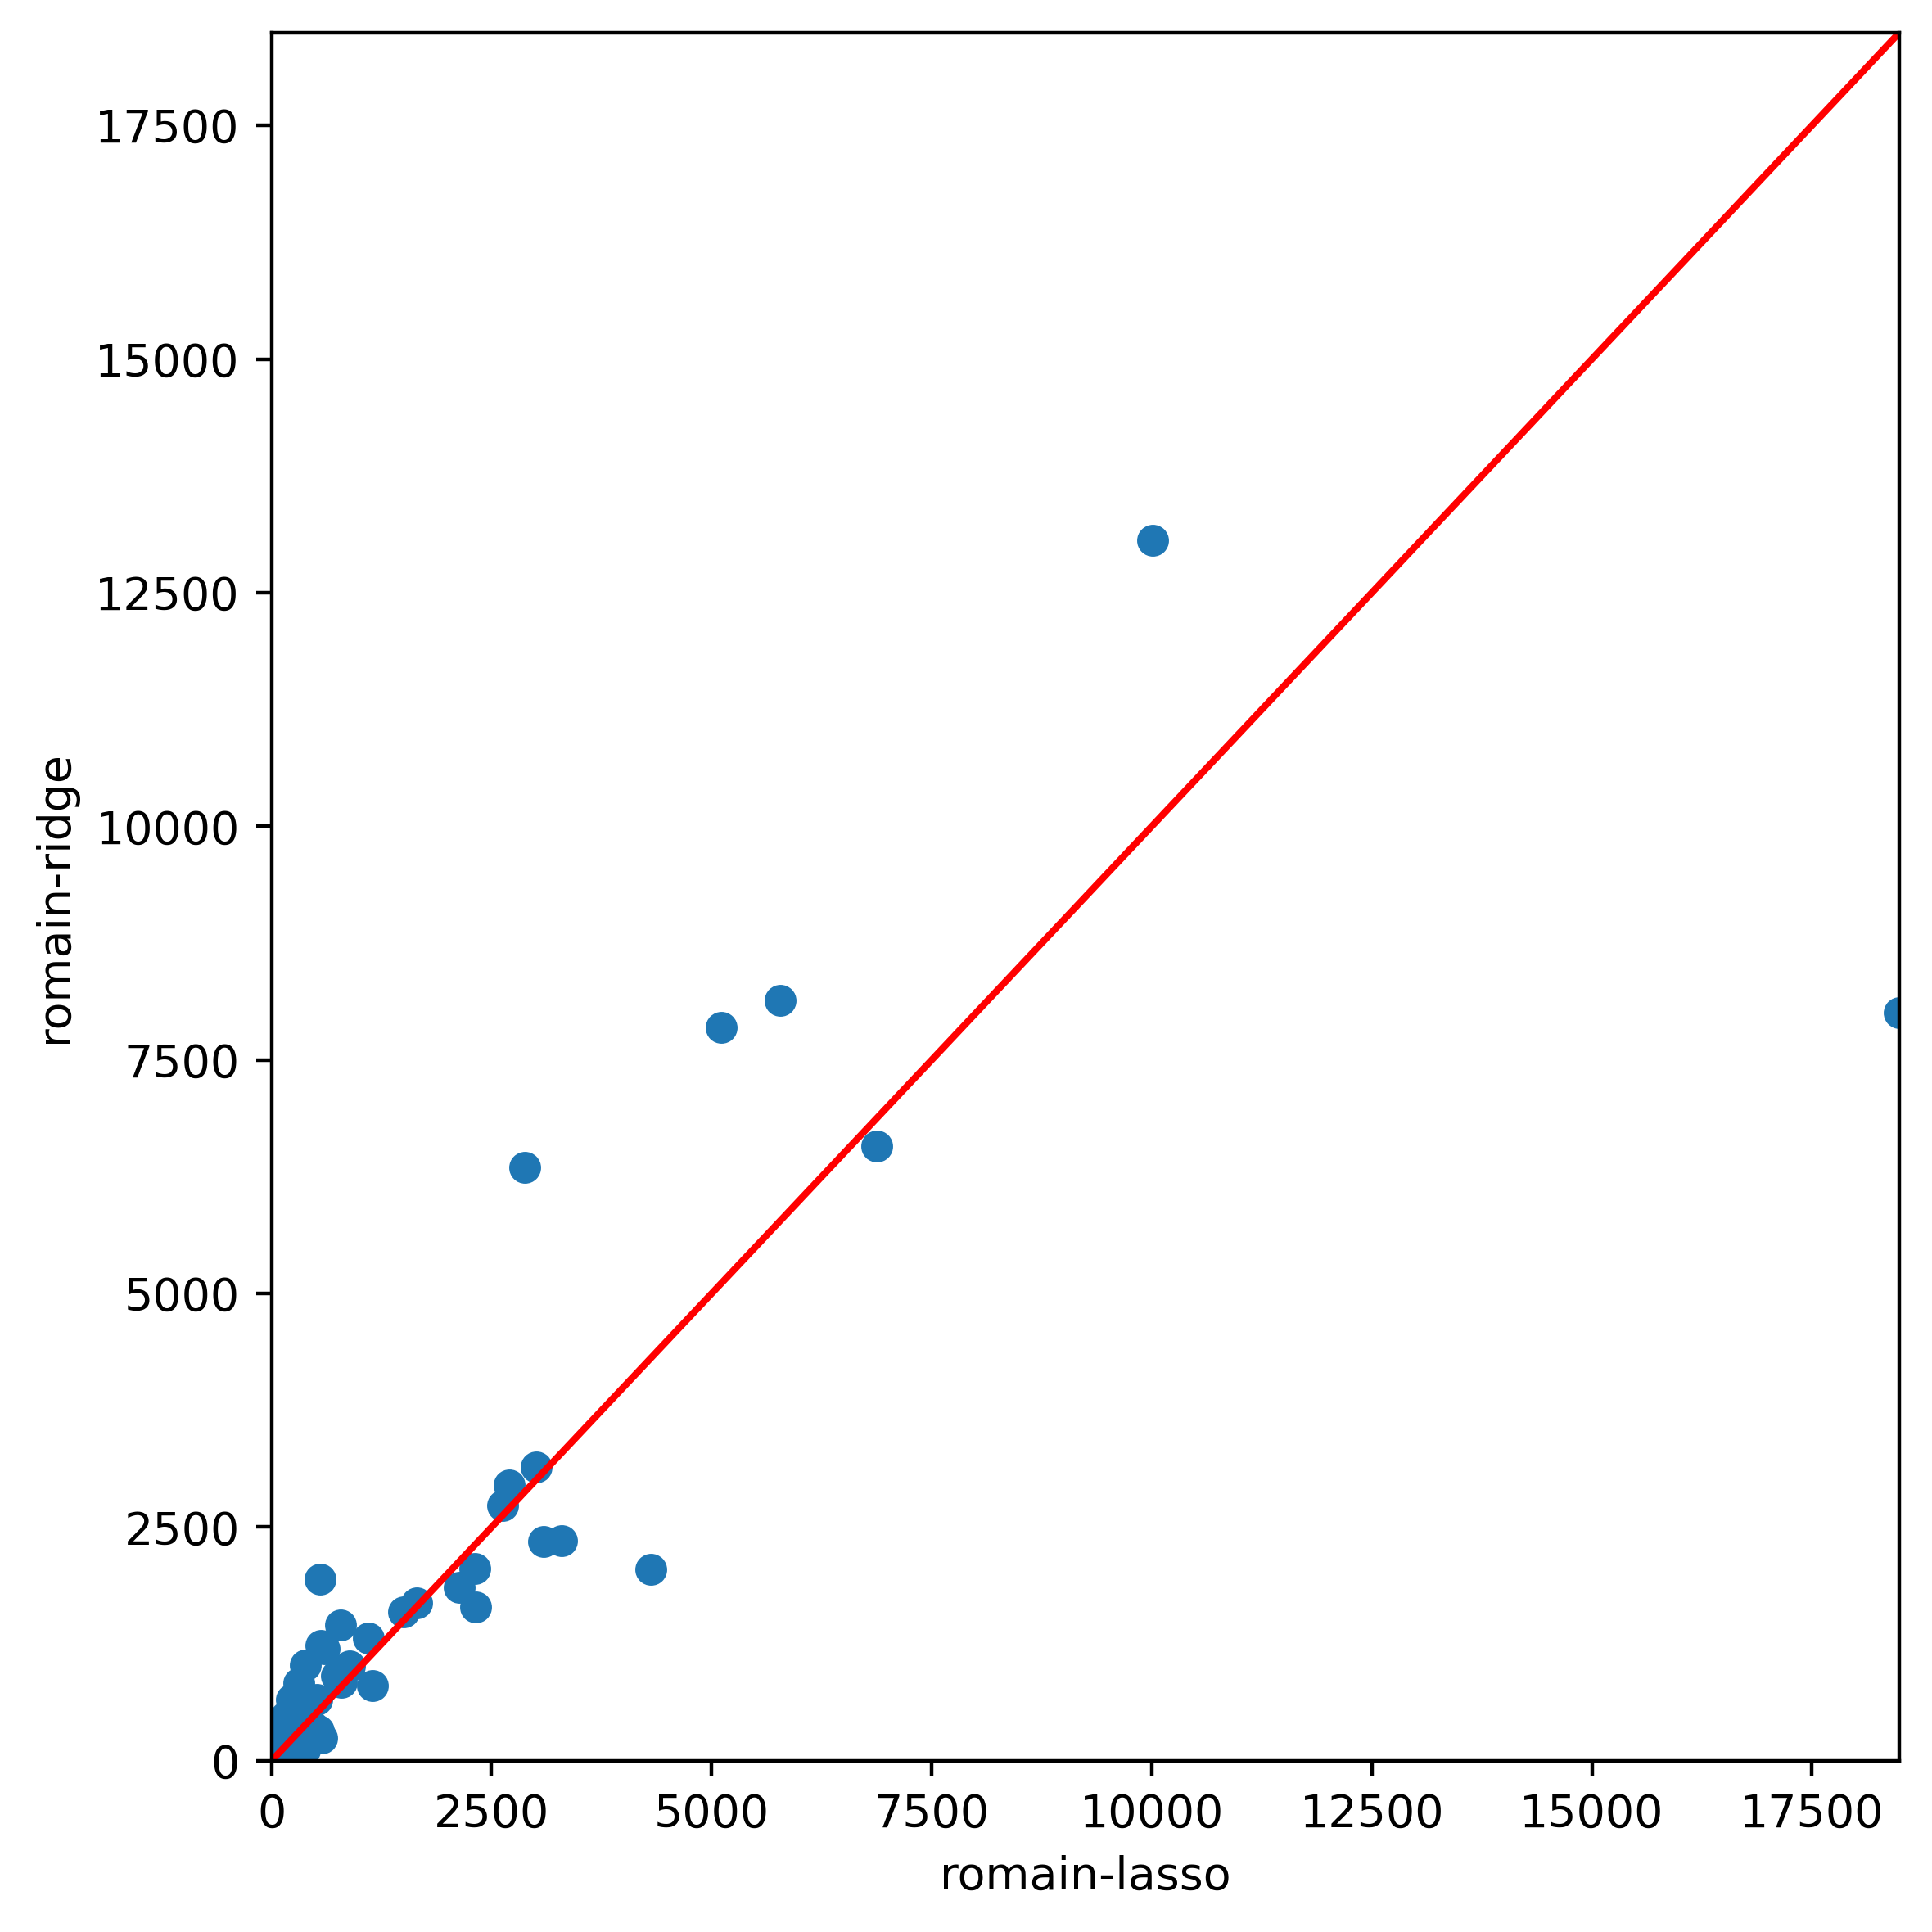

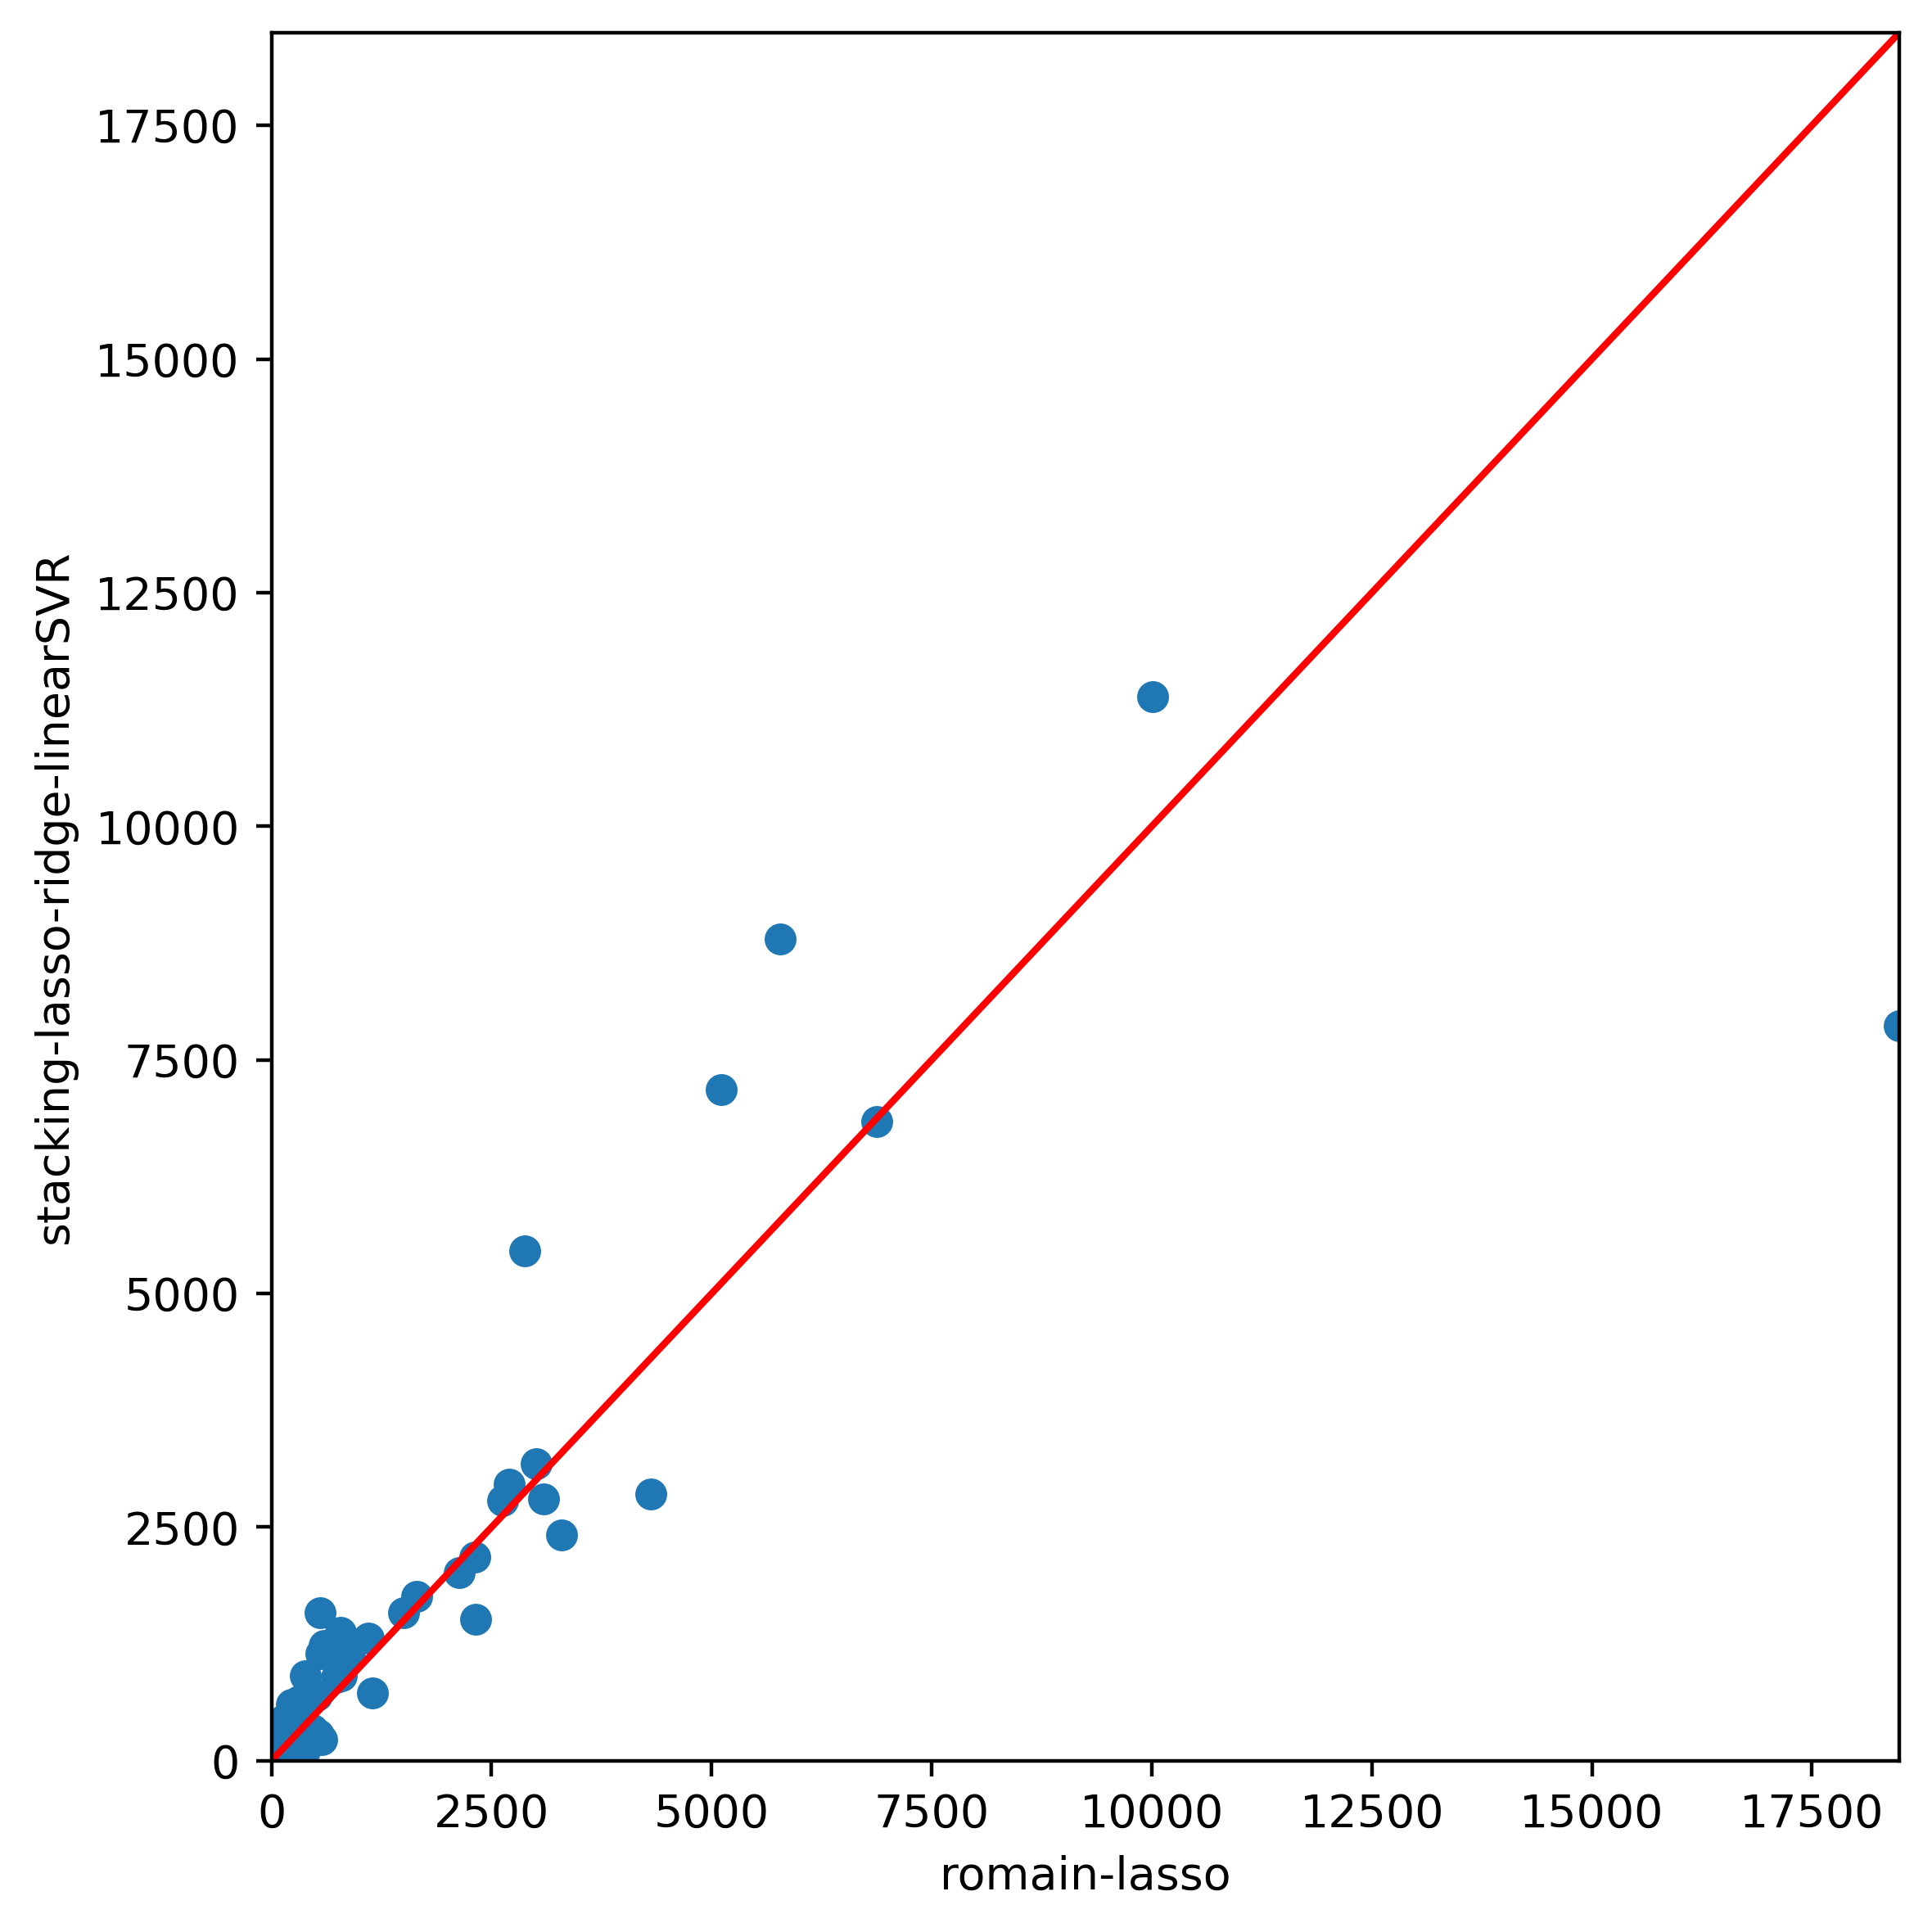

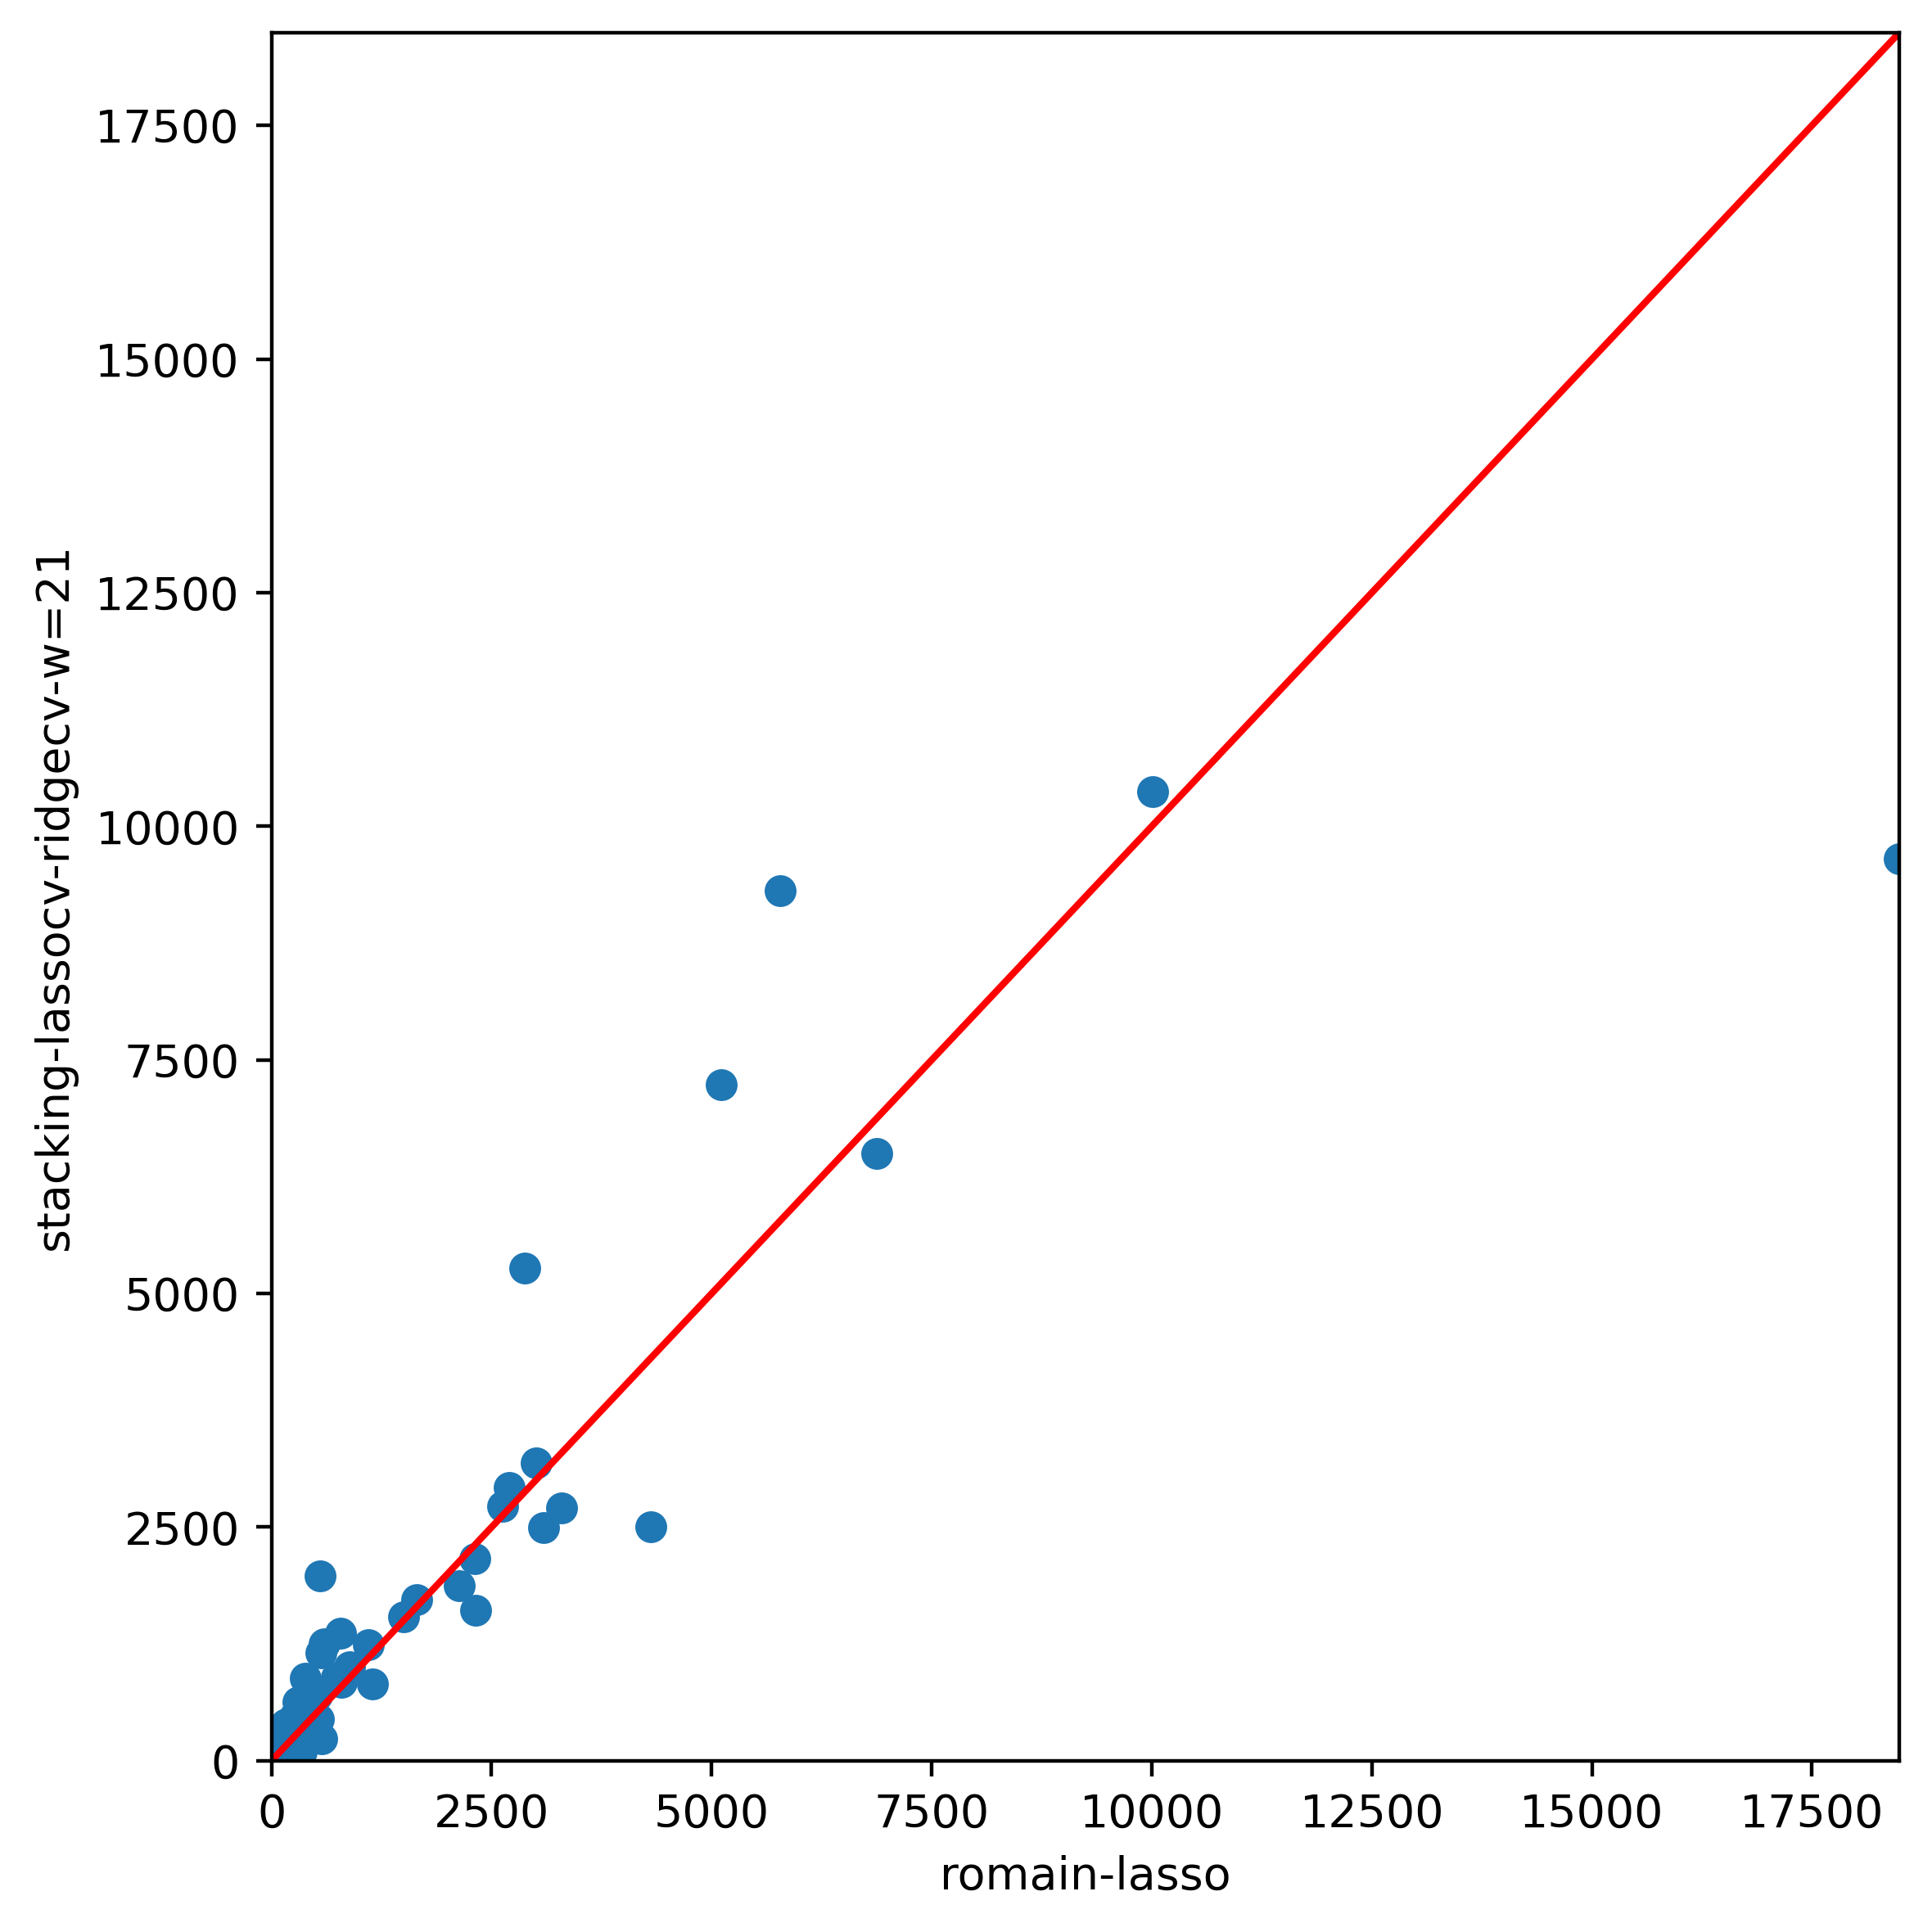

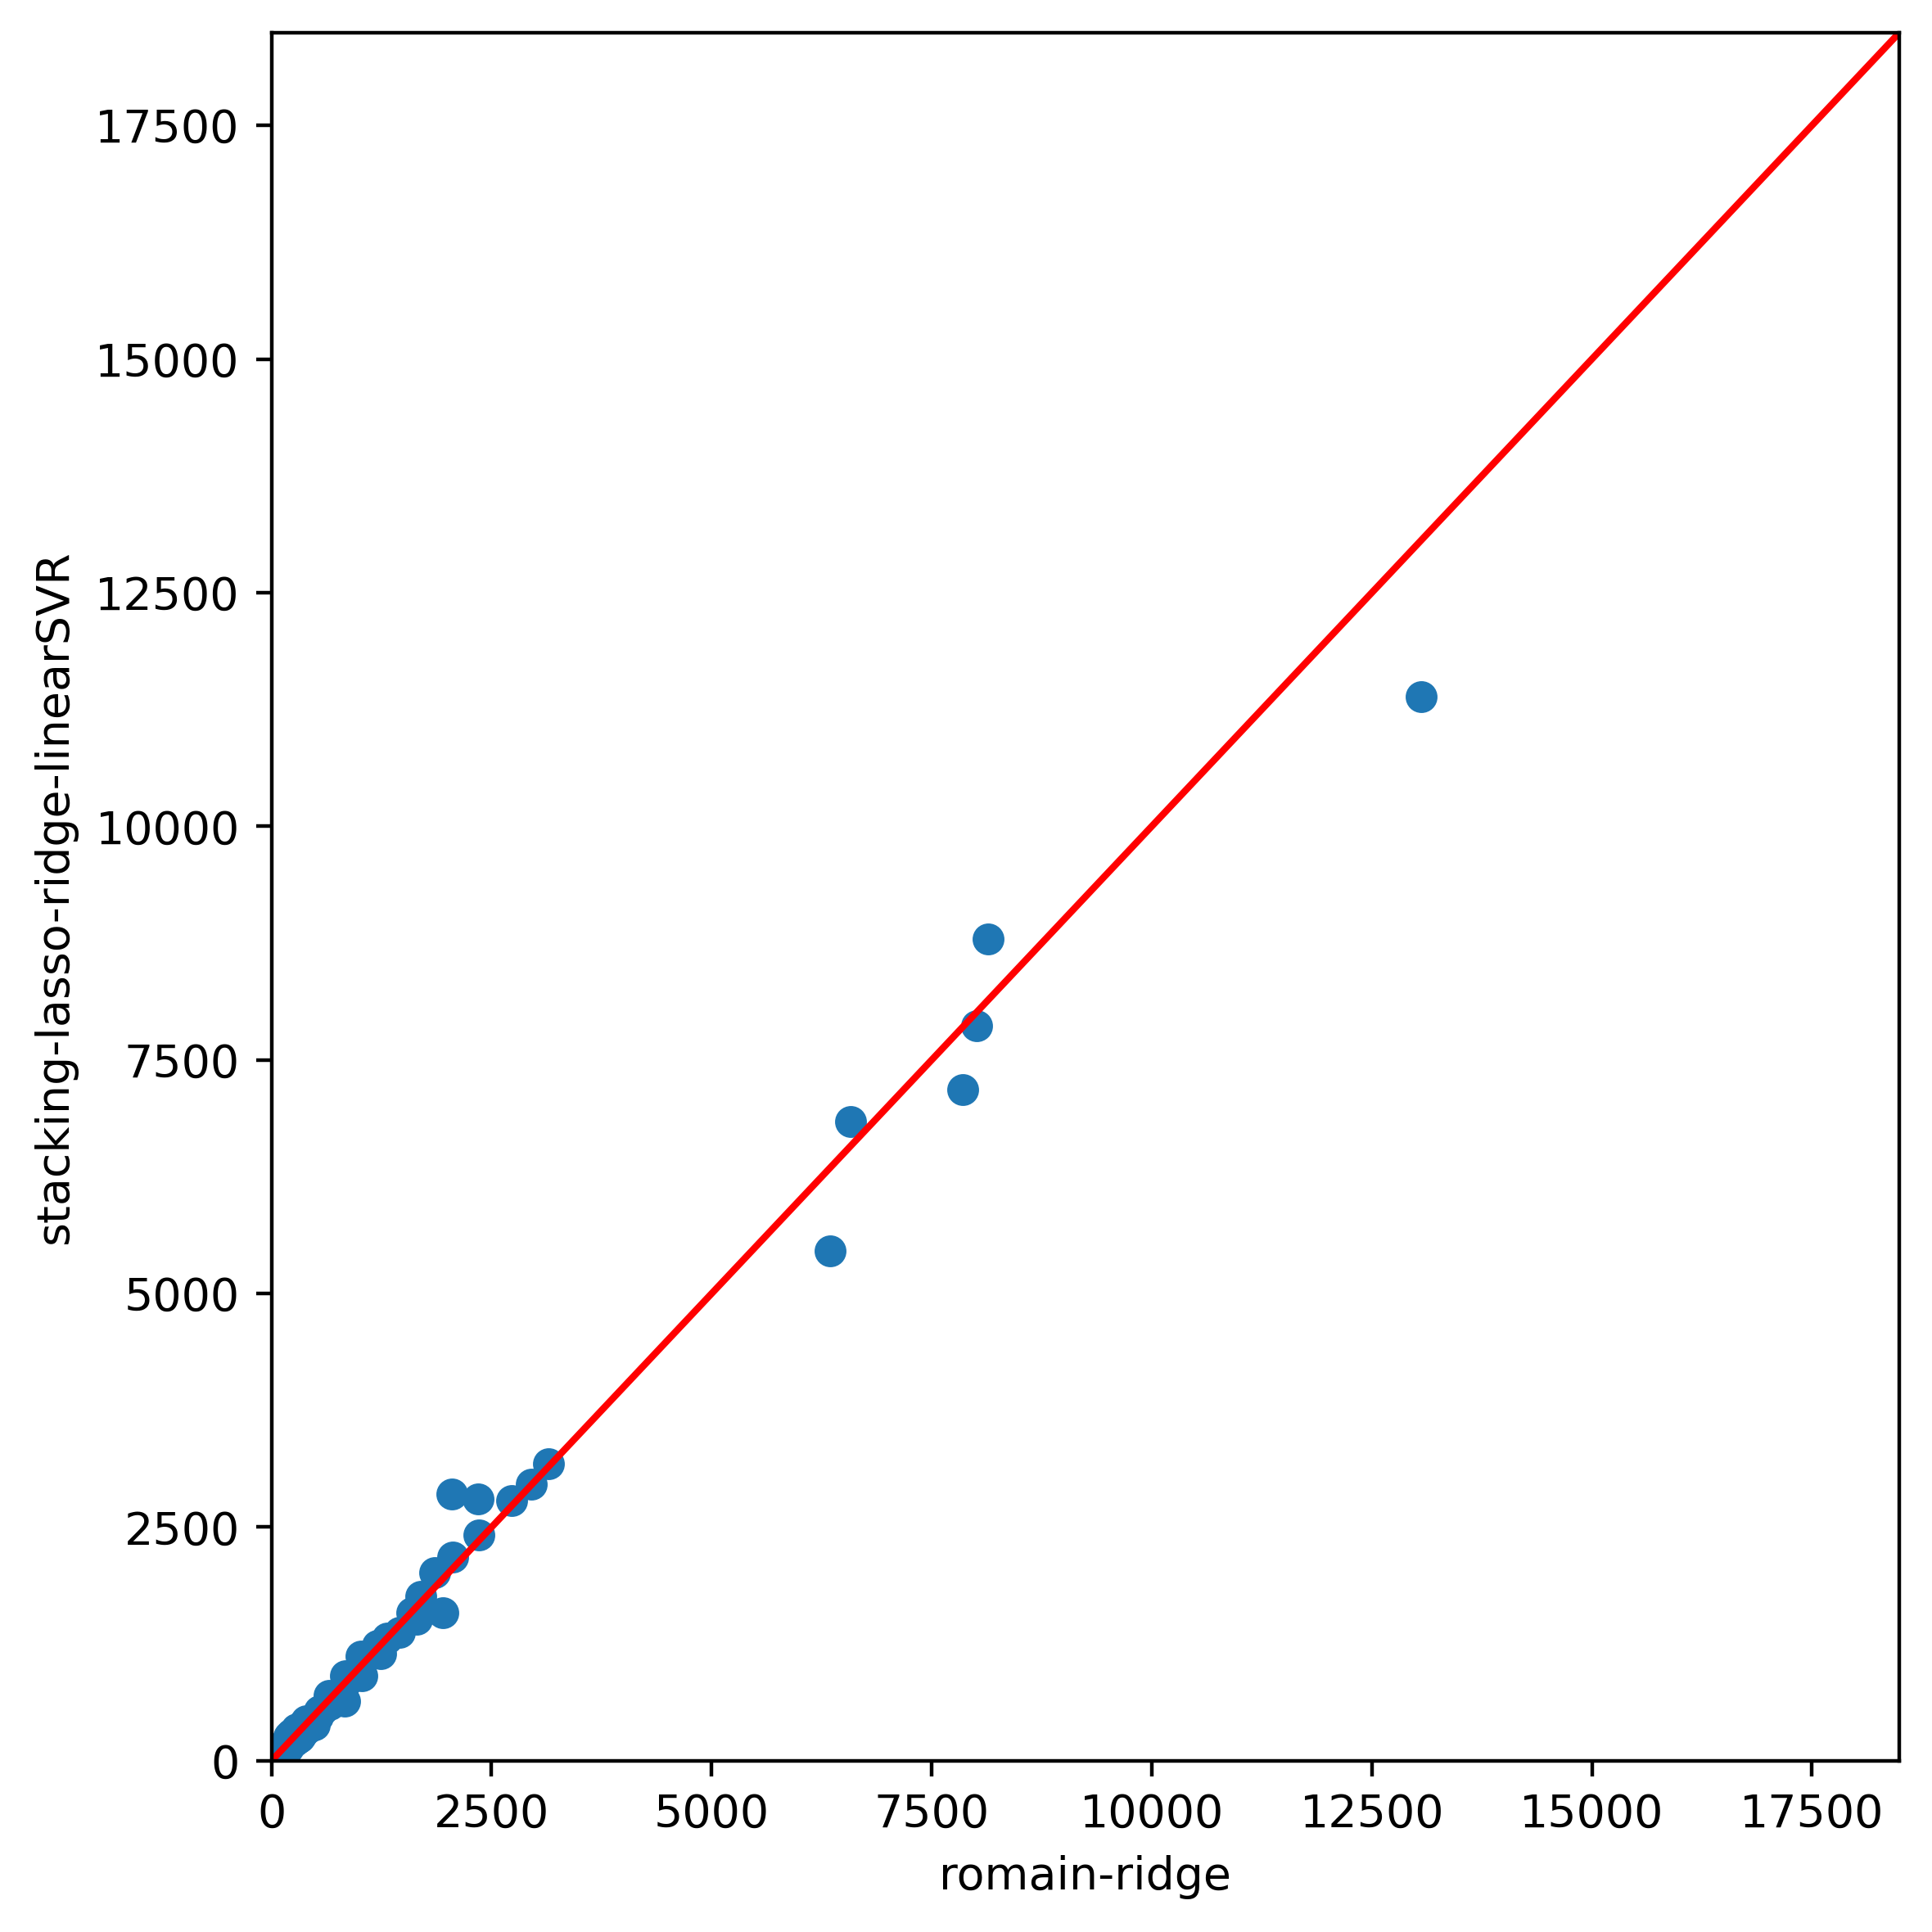

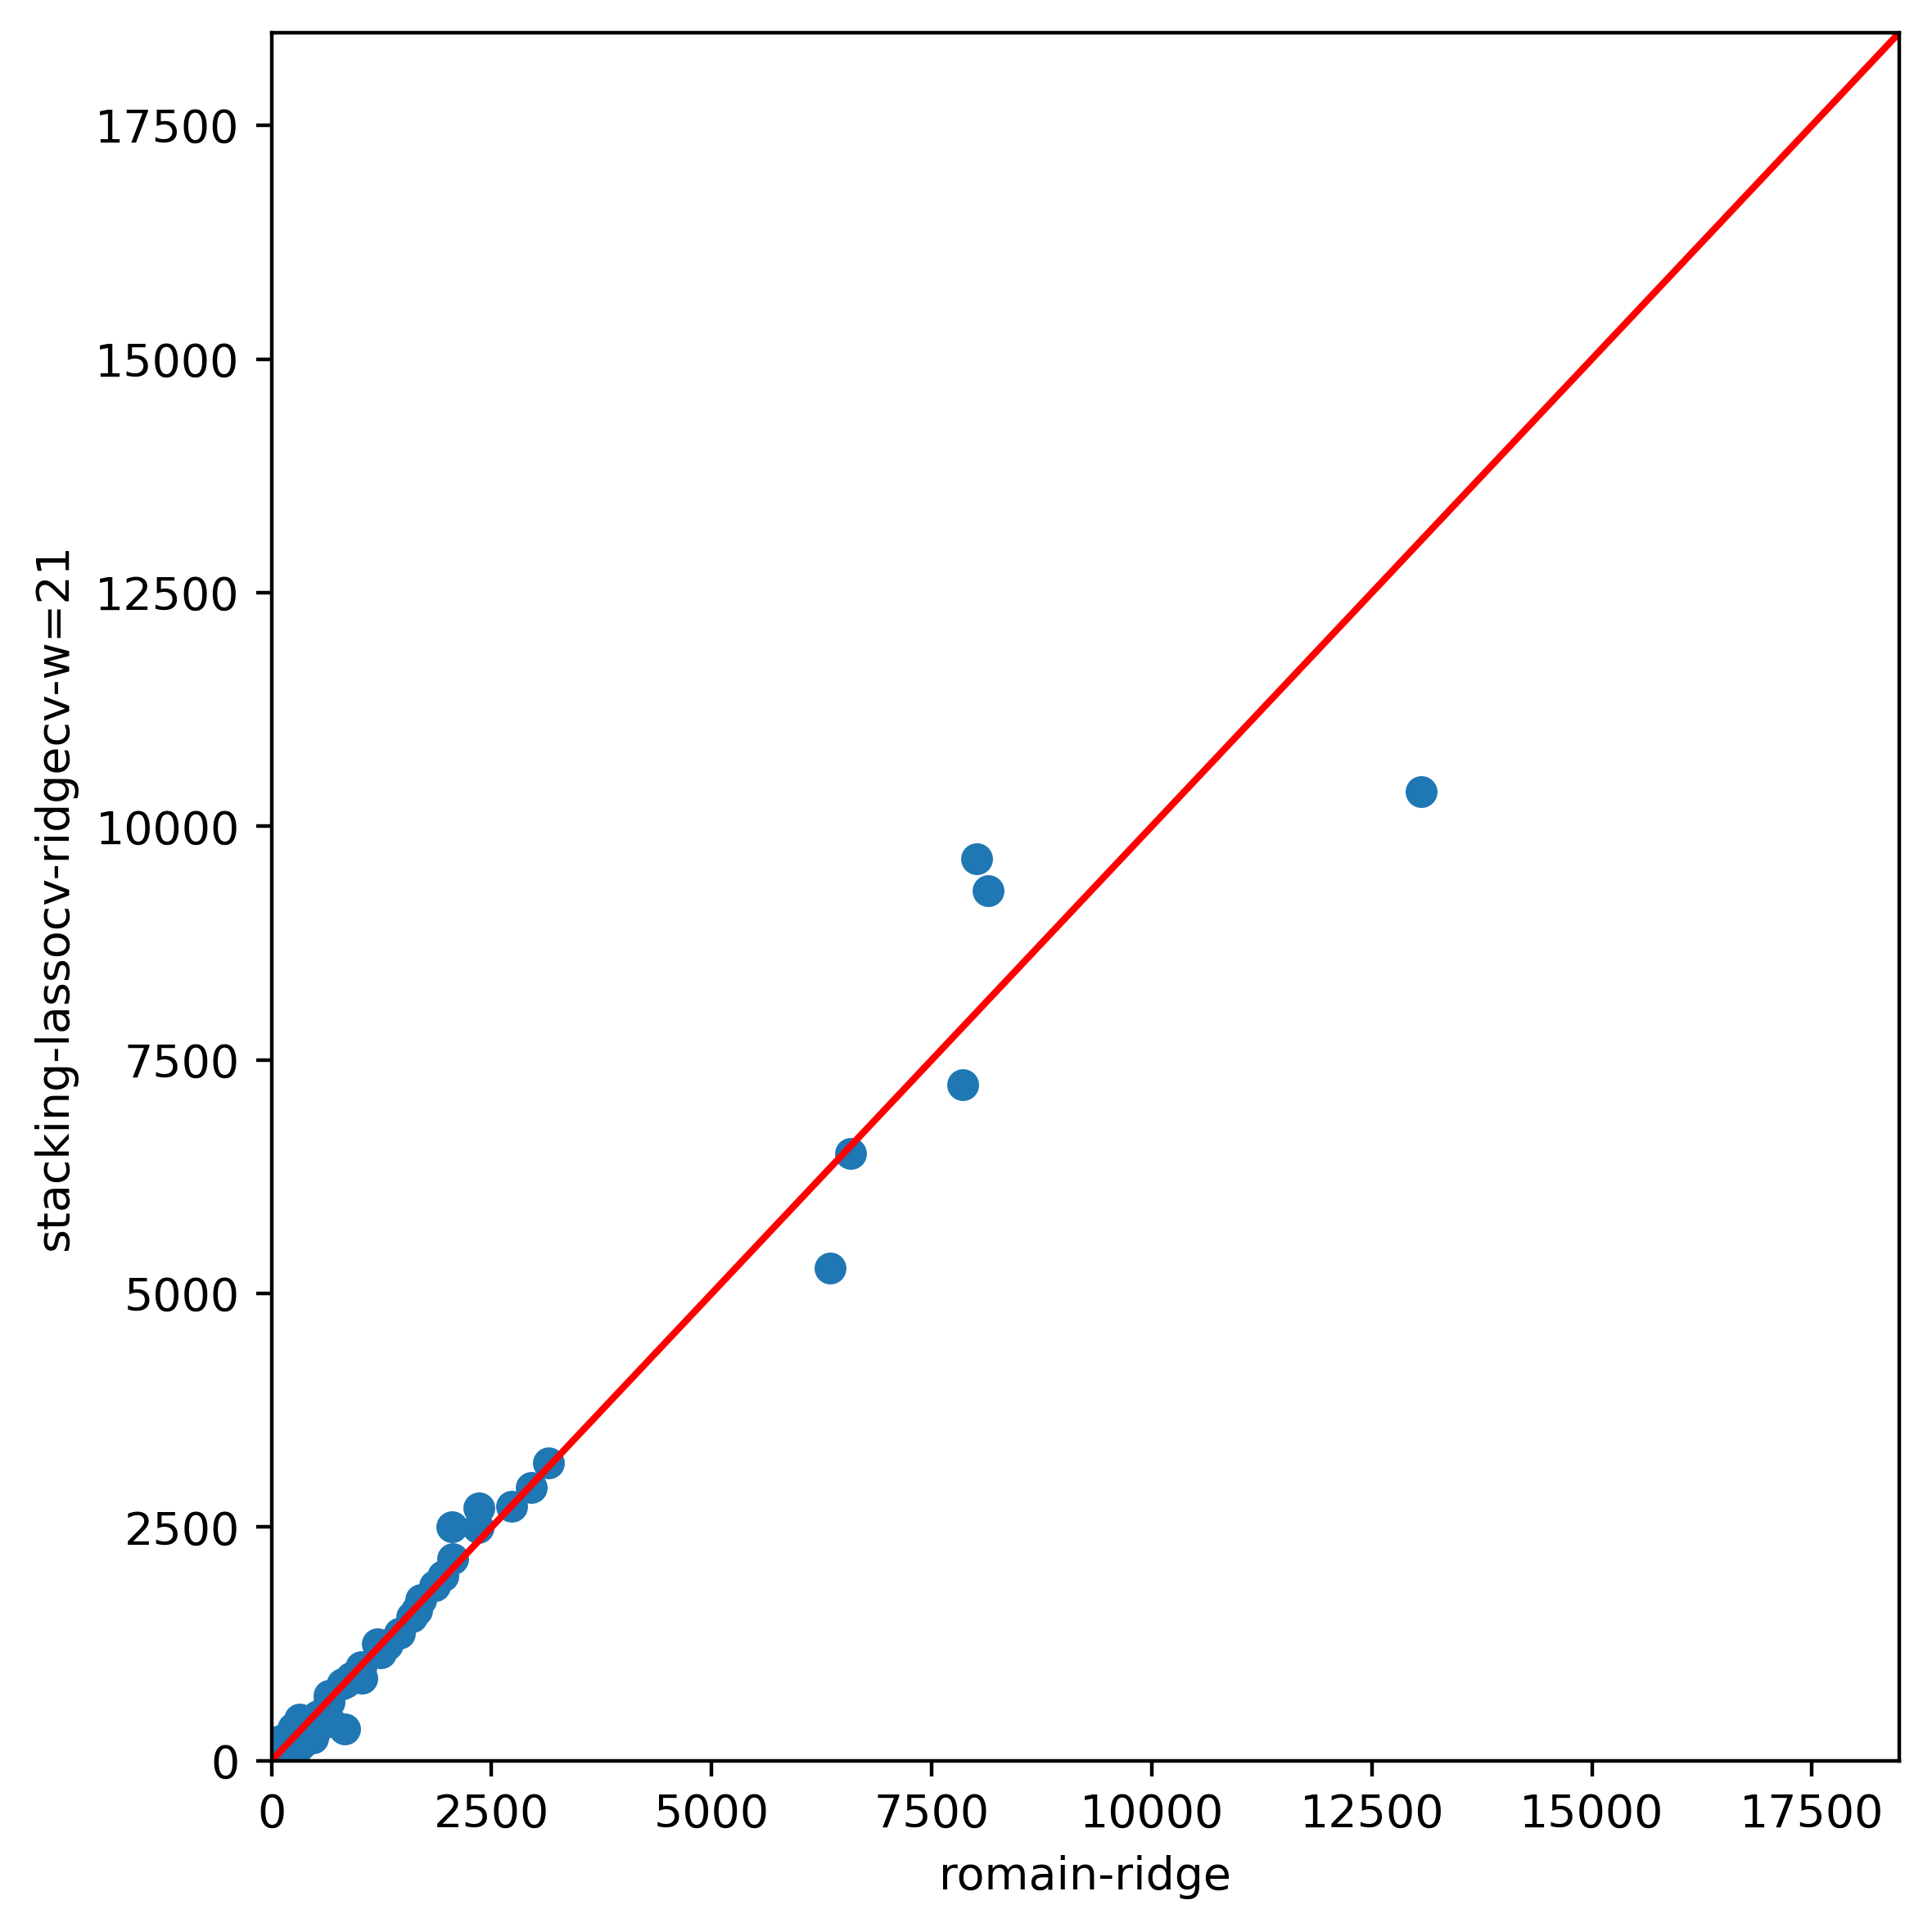

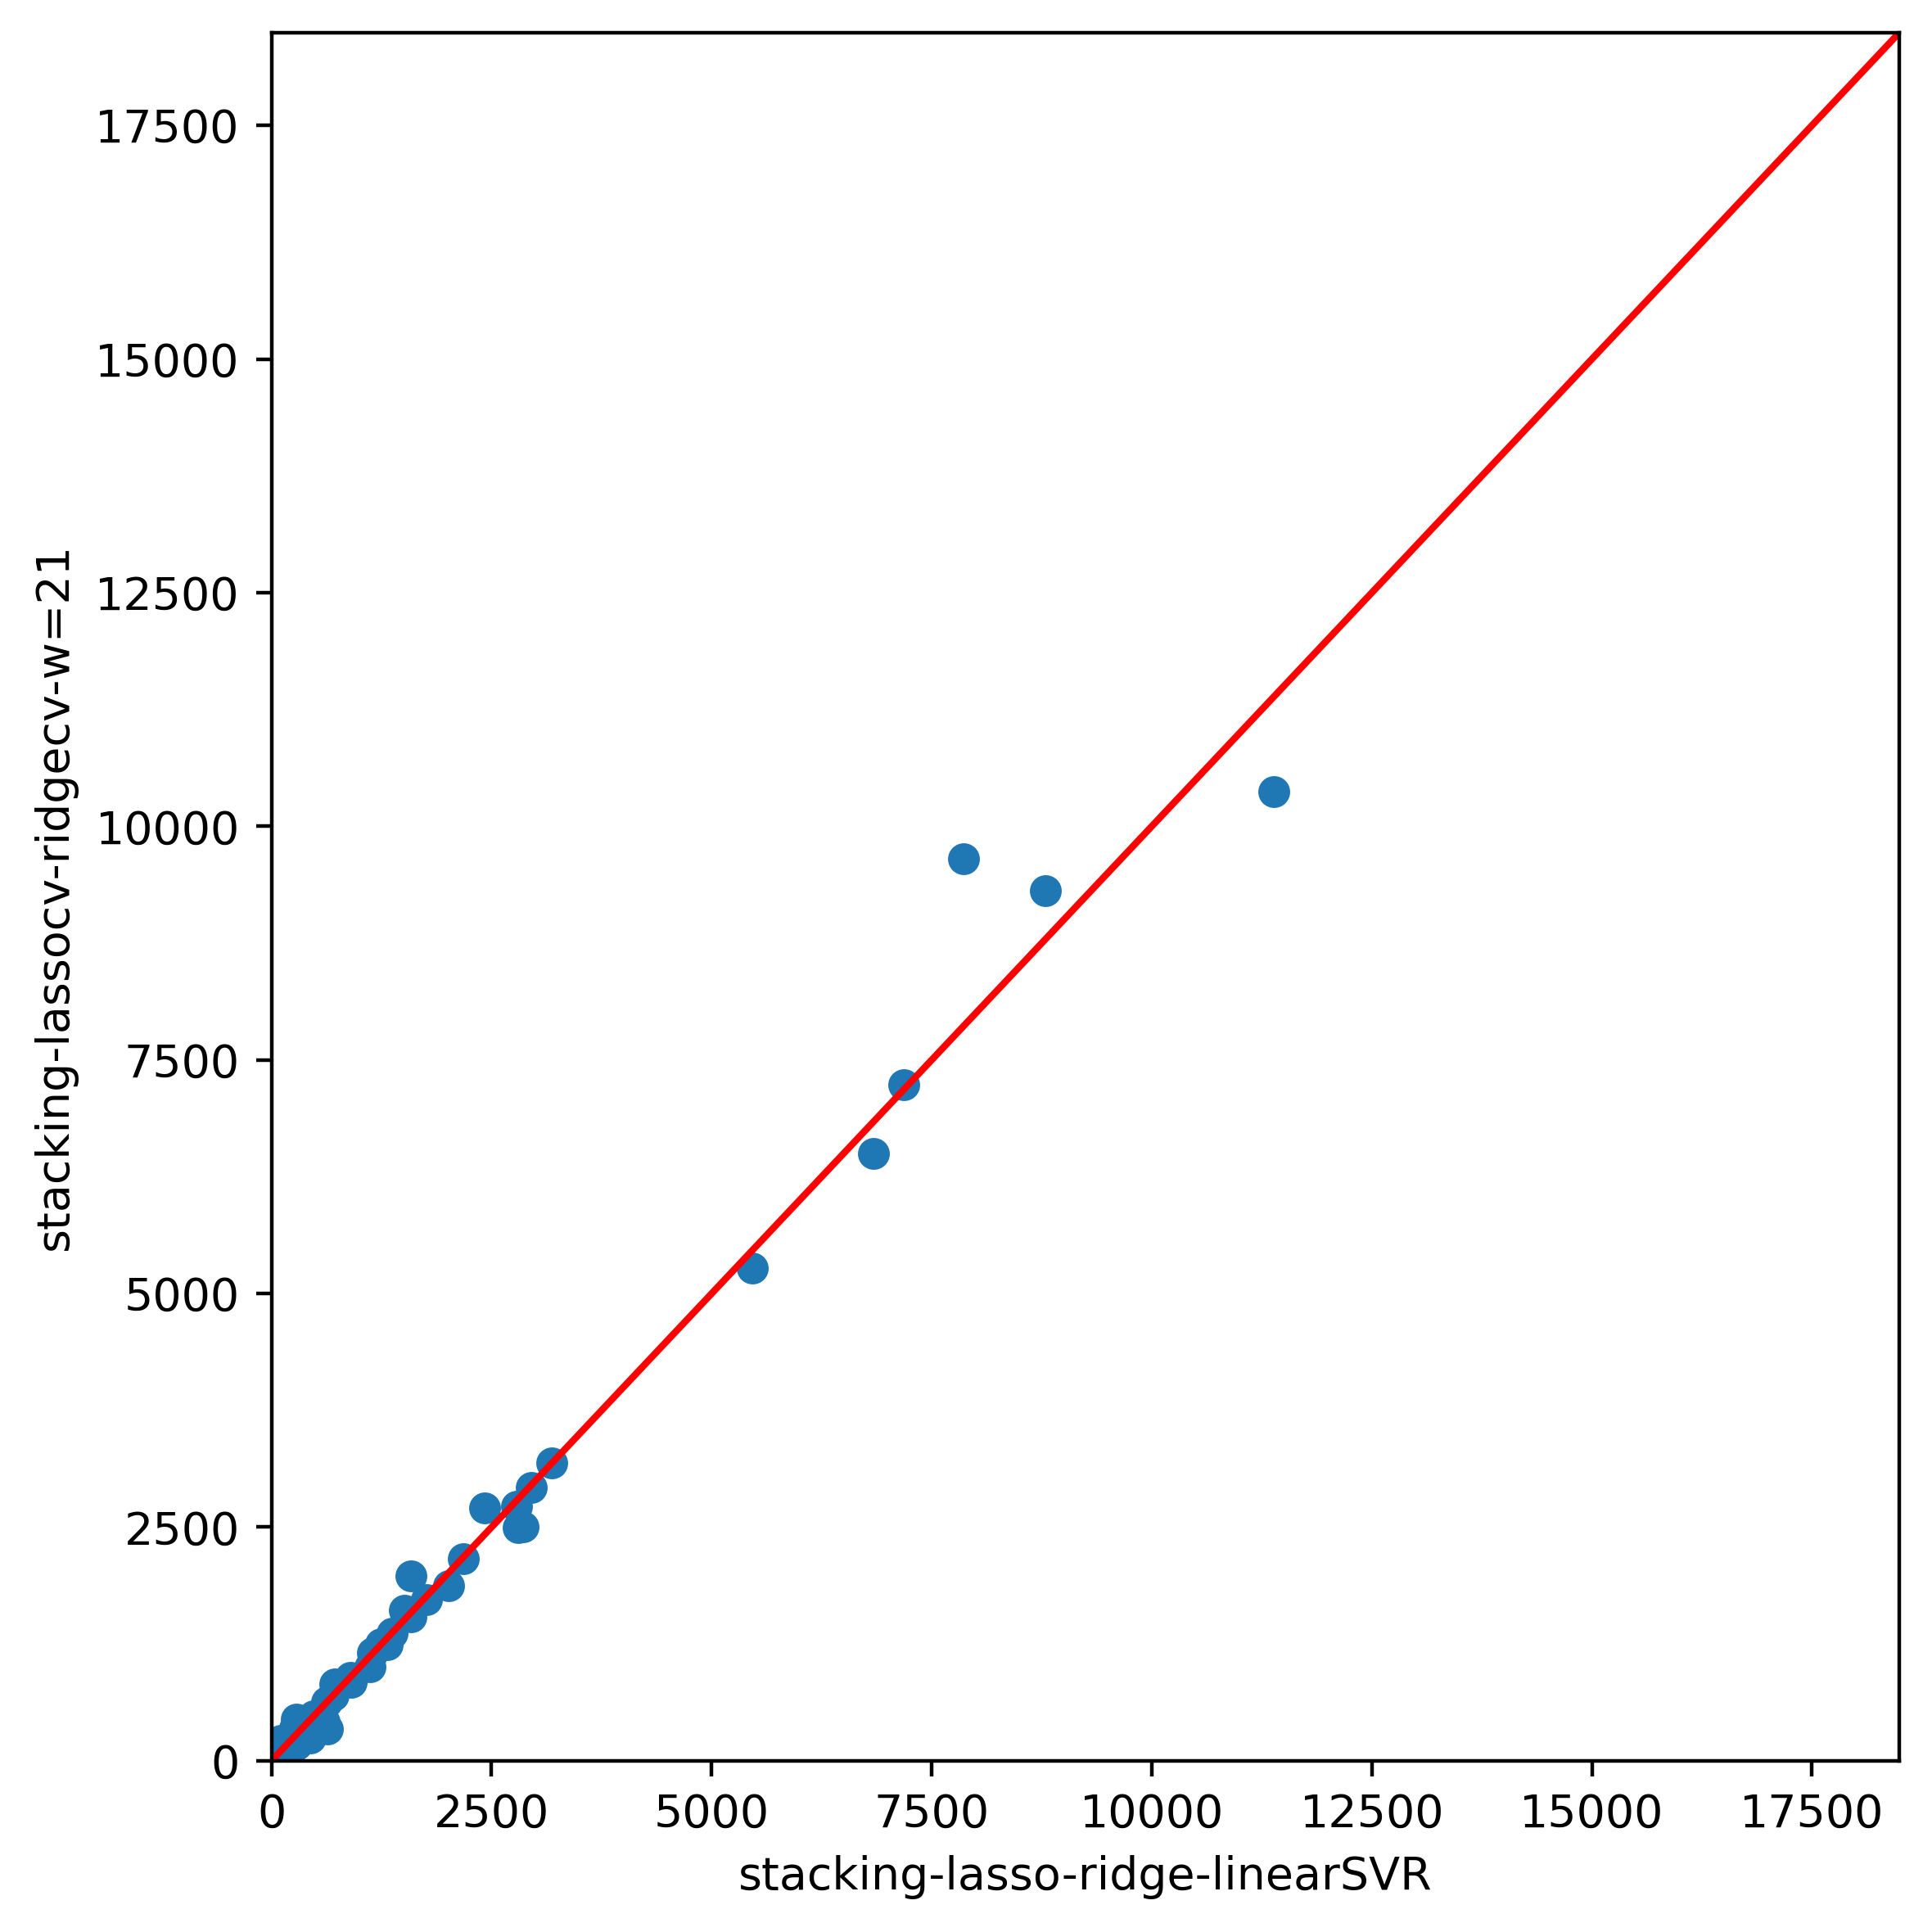

In [11]:
MAE_df = dfs[0]
# Recover model list

pairwise_models(MAE_df)

In [13]:
ranking_df = month_dfs[0]
plot_ranking(ranking_df)